In [ ]:
!pip -q install ultralytics==8.3.36

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 22.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Đường dẫn video (có thể là .mp4 hoặc .avi). Ví dụ:
VIDEO_PATH = "/content/car.mp4"
# VIDEO_PATH = "/content/EV20210223-032225-002874F.mp4"

# Tùy chọn: tạo thư mục output
OUT_DIR = Path("/content/output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ==== FCDW: Forward Car Distance Warning (tham số có thể chỉnh) ====

ALPHA = 1500.0      # hệ số ước lượng khoảng cách (phải tự tune theo camera của bạn)
WARN_DIST = 17.0    # m - khoảng cách cảnh báo (vàng)
DANGER_DIST = 10.0   # m - khoảng cách nguy hiểm (đỏ)

# Vùng "giữa" màn hình sẽ coi là vùng phía trước xe
CENTER_MIN = 0.30   # 30% bề rộng từ trái
CENTER_MAX = 0.70   # 70% bề rộng từ trái

def imshow_rgb(img_bgr, title="", size=12):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size, size*9/16))
    plt.imshow(img_rgb)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


In [ ]:
def build_trapezoid_roi(img_shape,
                        top_width_ratio=0.035,
                        bottom_width_ratio=0.40,
                        height_ratio=0.57,
                        bottom_crop_ratio=0.78,
                        top_shift_ratio=-0.007,
                        bottom_shift_ratio=-0.018):
    """
    Dời cạnh trên và cạnh dưới độc lập:
        top_shift_ratio:
            âm  -> dời cạnh trên sang trái
            dương -> dời cạnh trên sang phải
        bottom_shift_ratio:
            âm  -> dời cạnh dưới sang trái
            dương -> dời cạnh dưới sang phải
    """
    h, w = img_shape[:2]

    # Tọa độ chiều cao
    top_y = int(h * height_ratio)
    bottom_y = int(h * bottom_crop_ratio)

    # Độ rộng trên và dưới
    half_top = int(w * top_width_ratio * 0.5)
    half_bot = int(w * bottom_width_ratio * 0.5)

    # Tính tâm riêng cho cạnh trên và dưới
    top_cx = int(w * (0.5 + top_shift_ratio))
    bottom_cx = int(w * (0.5 + bottom_shift_ratio))

    # Bốn điểm ROI (cạnh trên và dưới dịch độc lập)
    pts = np.array([
        [top_cx - half_top, top_y],     # top-left
        [top_cx + half_top, top_y],     # top-right
        [bottom_cx + half_bot, bottom_y], # bottom-right
        [bottom_cx - half_bot, bottom_y]  # bottom-left
    ], dtype=np.int32)

    return pts


def apply_roi_mask(img, roi_pts):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [roi_pts], 255)
    if img.ndim == 3:
        masked = cv2.bitwise_and(img, img, mask=mask)
    else:
        masked = cv2.bitwise_and(img, mask)
    return masked, mask


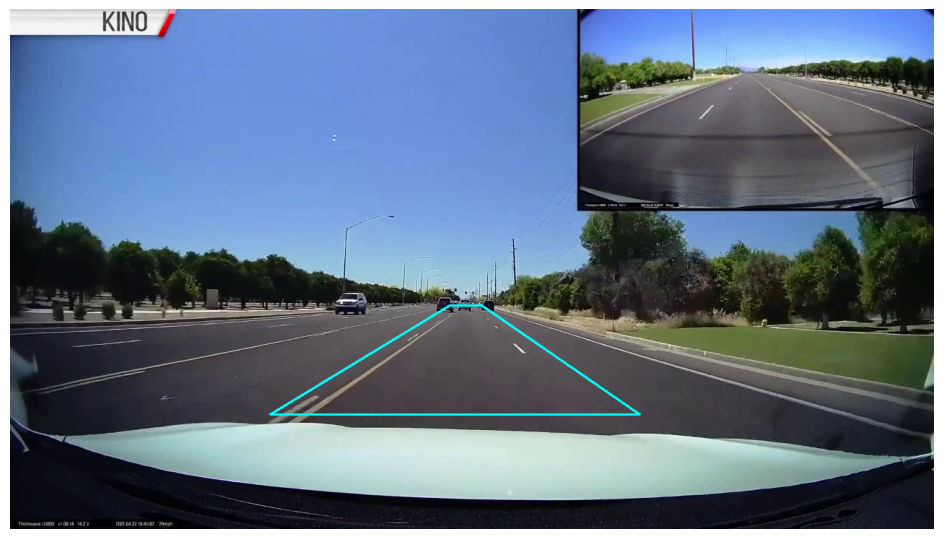

In [ ]:
# === Minh hoạ pipeline YOLO + FCDW trên 1 frame ===

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Không mở được video: {VIDEO_PATH}"

# Nhảy đến thời điểm t (giây) nếu muốn
t = 3
cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)

ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Không đọc được khung hình đầu tiên")

# ================== BƯỚC 1: XÁC ĐỊNH ROI (vùng quan tâm phía trước) ==================
roi_pts = build_trapezoid_roi(frame.shape)

overlay_roi = frame.copy()
cv2.polylines(overlay_roi, [roi_pts], isClosed=True,
              color=(255, 255, 0), thickness=2)

# Hiển thị: Bước 1 - ROI
imshow_rgb(overlay_roi)

In [ ]:
def canny_edges(gray, low=80, high=160):
    # Làm mượt nhẹ để giảm nhiễu biên
    blur = cv2.GaussianBlur(gray, (5,5), 1.0)
    edges = cv2.Canny(blur, low, high, L2gradient=True)
    return edges


In [ ]:
def average_slope_intercept(lines, img_shape):
    left_pts, right_pts = [], []
    h = img_shape[0]

    if lines is None:
        return None, None

    for ln in lines:
        x1, y1, x2, y2 = ln.reshape(-1)
        if x2 == x1:
            continue
        slope = (y2 - y1) / (x2 - x1 + 1e-6)
        if abs(slope) < 0.5:   # bỏ các line gần ngang
            continue
        intercept = y1 - slope * x1
        if slope < 0:
            left_pts.append((slope, intercept))
        else:
            right_pts.append((slope, intercept))

    def make_line(avg, y1, y2):
        m, b = avg
        x1 = int((y1 - b) / (m + 1e-6))
        x2 = int((y2 - b) / (m + 1e-6))
        return np.array([x1, y1, x2, y2])

    left_line = right_line = None
    y1, y2 = h - 1, int(h * 0.62)

    if len(left_pts) > 0:
        left_avg = np.mean(left_pts, axis=0)
        left_line = make_line(left_avg, y1, y2)

    if len(right_pts) > 0:
        right_avg = np.mean(right_pts, axis=0)
        right_line = make_line(right_avg, y1, y2)

    return left_line, right_line

def hough_lane_lines(edge_img, img_shape):
    lines = cv2.HoughLinesP(edge_img, rho=1, theta=np.pi/180, threshold=60,
                            minLineLength=40, maxLineGap=120)
    left, right = average_slope_intercept(lines, img_shape)
    return left, right


In [ ]:
def sobel_morph_edges(gray):
    gray_blur = cv2.GaussianBlur(gray, (5,5), 1.0)
    sobelx = cv2.Sobel(gray_blur, cv2.CV_16S, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_blur, cv2.CV_16S, 0, 1, ksize=3)
    sobel = cv2.convertScaleAbs(cv2.addWeighted(cv2.absdiff(sobelx, 0), 1.0,
                                                cv2.absdiff(sobely, 0), 1.0, 0))
    # Nhị phân & mở hình thái (morphological opening)
    _, th = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opened = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    return opened


In [ ]:
def estimate_distance_from_box(box, alpha=ALPHA):
    """
    box: (x1, y1, x2, y2) theo pixel
    trả về: khoảng cách d (m) ~ alpha / h_box
    """
    x1, y1, x2, y2 = box
    h_box = max(1, y2 - y1)   # tránh chia 0
    d = alpha / float(h_box)
    return d


def select_front_vehicle(boxes, img_shape, roi_pts, overlap_thresh=0.3):
    """
    Chọn xe phía trước dựa trên tỷ lệ bbox nằm trong ROI.
    - boxes: list of (x1, y1, x2, y2)
    - roi_pts: polygon ROI
    - overlap_thresh: tỷ lệ tối thiểu (vd 0.3 = 30%)
    """

    if not boxes:
        return None

    h, w = img_shape[:2]

    # 1) Mask ROI
    roi_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(roi_mask, [roi_pts], 255)

    best_idx = None
    best_height = 0

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        # BBOX mask
        bbox_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.rectangle(bbox_mask, (x1, y1), (x2, y2), 255, -1)

        # 2) Tính vùng giao nhau giữa bbox & ROI
        intersection = cv2.bitwise_and(roi_mask, bbox_mask)

        # Diện tích bbox
        bbox_area = (x2 - x1) * (y2 - y1)
        if bbox_area <= 0:
            continue

        # Diện tích giao nhau
        inter_area = np.sum(intersection == 255)

        # 3) Tỷ lệ overlap
        overlap_ratio = inter_area / bbox_area

        # 4) Lọc theo ngưỡng (30% mặc định)
        if overlap_ratio < overlap_thresh:
            continue

        # 5) Chọn xe gần nhất (bbox cao nhất)
        h_box = y2 - y1
        if h_box > best_height:
            best_height = h_box
            best_idx = i

    return best_idx

In [ ]:
# Model nhỏ, nhanh cho Colab. Sẽ tự tải trọng số COCO.
yolo = YOLO("yolov8n.pt")
yolo.to("cuda")

# Chỉ giữ các lớp "car", "truck", "bus", "motorbike"
WANTED = {2, 3, 5, 7}  # class ids theo COCO


100%|██████████| 6.25M/6.25M [00:00<00:00, 121MB/s]


In [ ]:
def draw_lanes(img, left_line, right_line, color_left=(255,0,0), color_right=(0,255,0), thickness=8):
    out = img.copy()
    for line, color in [(left_line, color_left), (right_line, color_right)]:
        if line is not None:
            x1, y1, x2, y2 = line
            cv2.line(out, (x1,y1), (x2,y2), color, thickness, cv2.LINE_AA)
    return out

def draw_boxes(img, boxes, labels=None,
               front_idx=None,
               default_color=(255,255,0),
               front_color=(0,0,255)):
    """
    Nếu front_idx != None thì box đó sẽ vẽ bằng front_color (ví dụ: đỏ).
    Các box khác vẽ bằng default_color (xanh lá).
    """
    out = img.copy()
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        color = front_color if (front_idx is not None and i == front_idx) else default_color
        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
        if labels:
            cv2.putText(out, labels[i], (x1, max(20, y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out



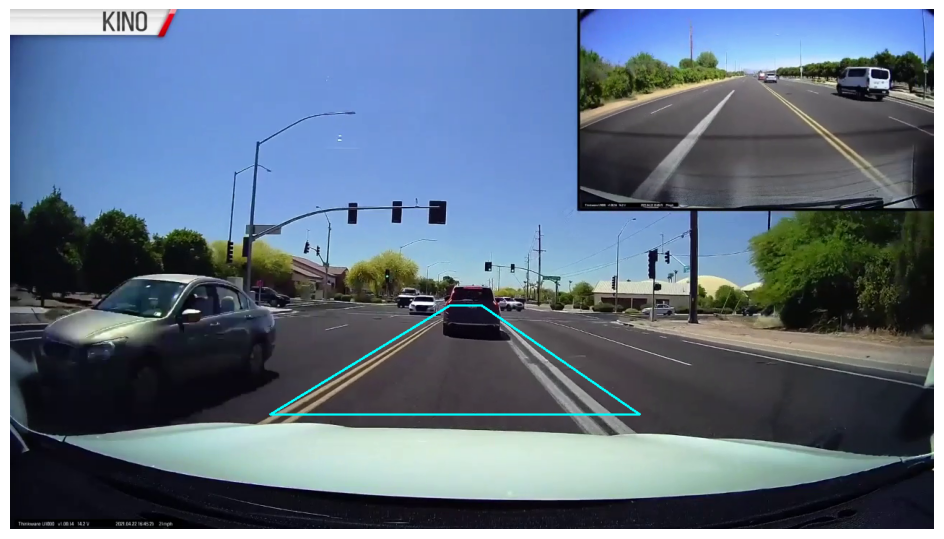

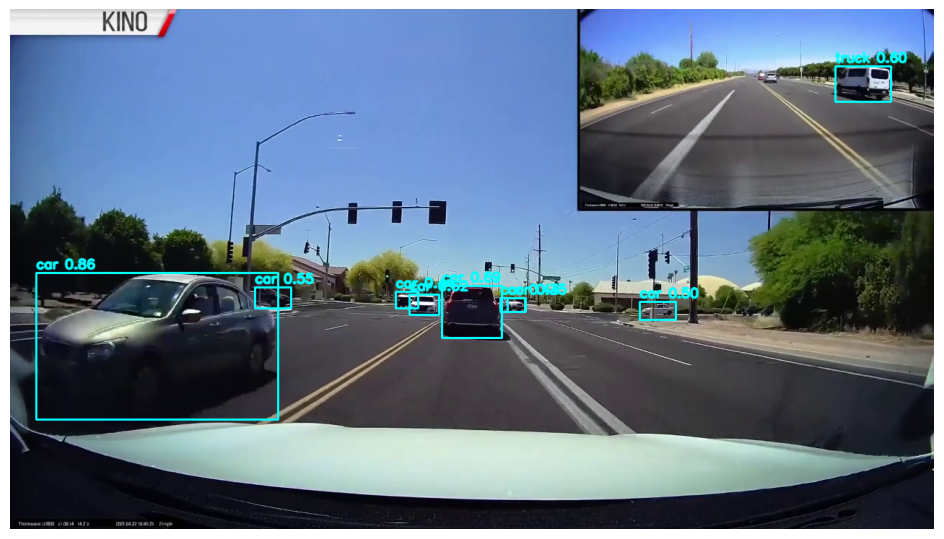

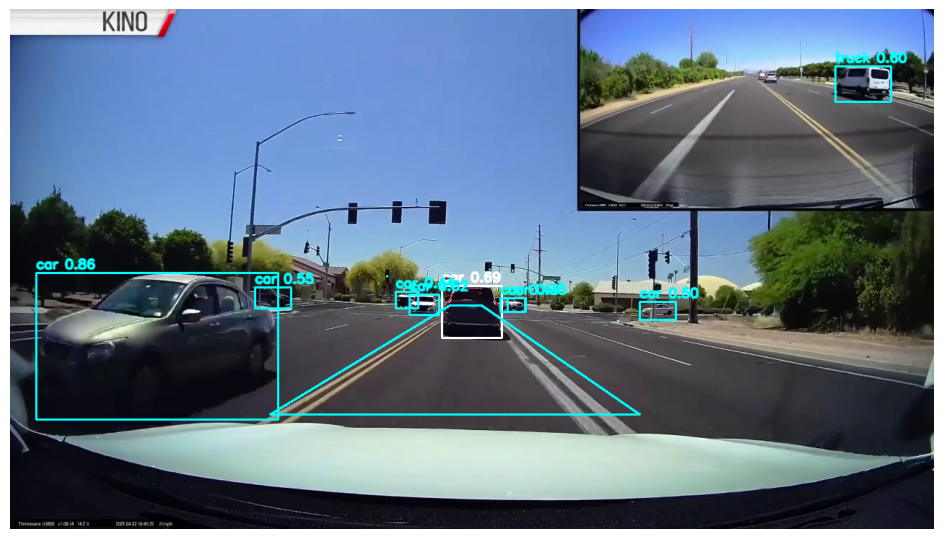

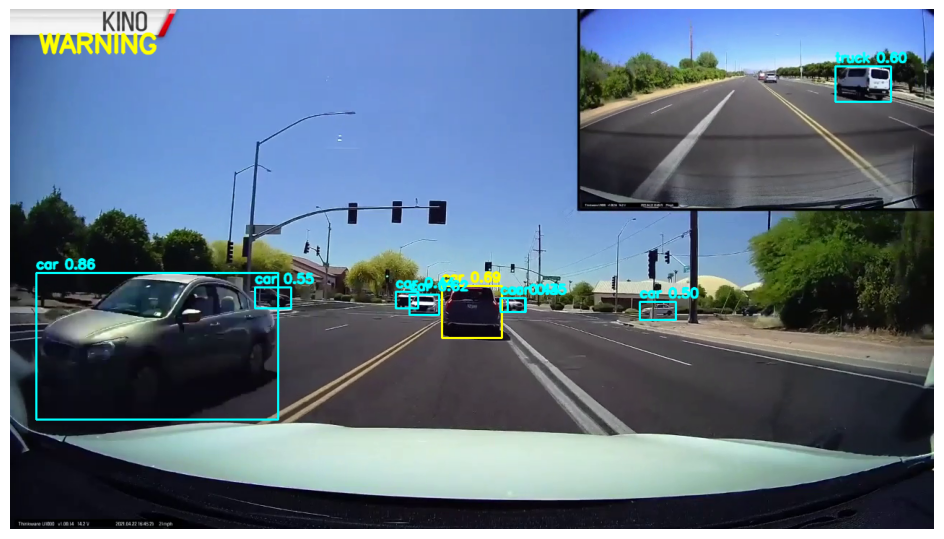

In [ ]:


# === Minh hoạ pipeline YOLO + FCDW trên 1 frame ===

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Không mở được video: {VIDEO_PATH}"

# Nhảy đến thời điểm t (giây) nếu muốn
t = 6.5
cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)

ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Không đọc được khung hình đầu tiên")

# ================== BƯỚC 1: XÁC ĐỊNH ROI (vùng quan tâm phía trước) ==================
roi_pts = build_trapezoid_roi(frame.shape)

overlay_roi = frame.copy()
cv2.polylines(overlay_roi, [roi_pts], isClosed=True,
              color=(255, 255, 0), thickness=2)

# Hiển thị: Bước 1 - ROI
imshow_rgb(overlay_roi)

# ================== BƯỚC 2: YOLO PHÁT HIỆN PHƯƠNG TIỆN ==================
res = yolo(frame, verbose=False, imgsz=960)[0]
boxes, labels = [], []
for b, c, conf in zip(res.boxes.xyxy.cpu().numpy().astype(int),
                      res.boxes.cls.cpu().numpy().astype(int),
                      res.boxes.conf.cpu().numpy()):
    if c in WANTED and conf >= 0.35:
        x1, y1, x2, y2 = b.tolist()
        boxes.append((x1, y1, x2, y2))
        labels.append(f"{yolo.names[int(c)]} {conf:.2f}")

# Vẽ tất cả xe được YOLO phát hiện (chưa FCDW)
yolo_all = draw_boxes(frame.copy(), boxes, labels)
imshow_rgb(yolo_all)

# ================== BƯỚC 3: CHỌN XE PHÍA TRƯỚC (FRONT VEHICLE SELECTION) ==================
front_idx = select_front_vehicle(boxes, frame.shape, roi_pts)

# Vẽ lại, đánh dấu xe phía trước bằng màu khác (ví dụ: cyan)
front_color_tmp = (255, 255, 255)  # màu khác để minh hoạ
yolo_front = draw_boxes(frame.copy(), boxes, labels,
                        front_idx=front_idx,
                        front_color=front_color_tmp)
# Vẽ lại ROI cho đồng bộ với các bước trước
cv2.polylines(yolo_front, [roi_pts], isClosed=True,
              color=(255, 255, 0), thickness=2)

imshow_rgb(yolo_front)

# ================== BƯỚC 4: ƯỚC LƯỢNG KHOẢNG CÁCH + PHÂN LOẠI CẢNH BÁO ==================
status_text = ""
front_color = (0, 255, 0)  # default: Safe = xanh lá
text_color = (0, 255, 0)

if front_idx is not None:
    d = estimate_distance_from_box(boxes[front_idx], alpha=ALPHA)

    if d < DANGER_DIST:
        status_text = "DANGER"
        front_color = (0, 0, 255)    # red
        text_color = (0, 0, 255)
    elif d < WARN_DIST:
        status_text = "WARNING"
        front_color = (0, 255, 255)  # yellow
        text_color = (0, 255, 255)
    else:
        status_text = "SAFE"
        front_color = (0, 255, 0)    # green
        text_color = (0, 255, 0)

# ================== BƯỚC 5: HIỂN THỊ KẾT QUẢ FCDW CUỐI CÙNG ==================
# Vẽ bounding box + lane (nếu bạn muốn kèm làn)
# Nếu không cần lane ở minh hoạ này thì dùng trực tiếp frame.copy()

out_fcdw = frame.copy()
# Nếu bạn đã có lane detection:
# frame_roi, _ = apply_roi_mask(frame, roi_pts)
# gray = cv2.cvtColor(frame_roi, cv2.COLOR_BGR2GRAY)
# edges = canny_edges(gray)
# left_line, right_line = hough_lane_lines(edges, frame.shape)
# out_fcdw = draw_lanes(out_fcdw, left_line, right_line)

# Vẽ bounding boxes với front_color đúng mức cảnh báo
out_fcdw = draw_boxes(out_fcdw, boxes, labels,
                      front_idx=front_idx,
                      front_color=front_color)

# Vẽ lại ROI cho đồng bộ với các bước trước
# cv2.polylines(out_fcdw, [roi_pts], isClosed=True,
#               color=(255, 255, 0), thickness=2)

# In chữ cảnh báo (DANGER / Warning / Safe) trực tiếp lên ảnh
if front_idx is not None and status_text:
    cv2.putText(out_fcdw, status_text, (40, 60),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.2, text_color, 3, cv2.LINE_AA)

imshow_rgb(out_fcdw)

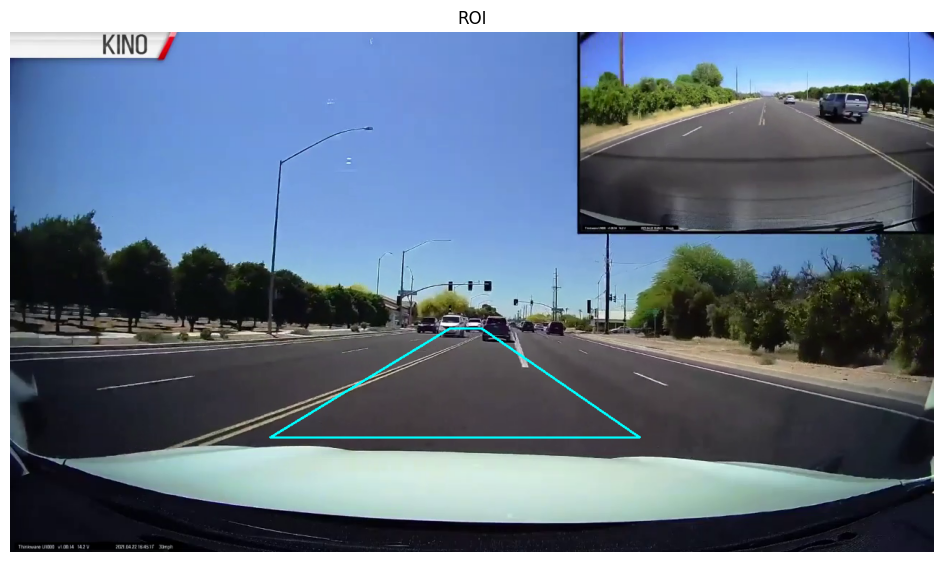

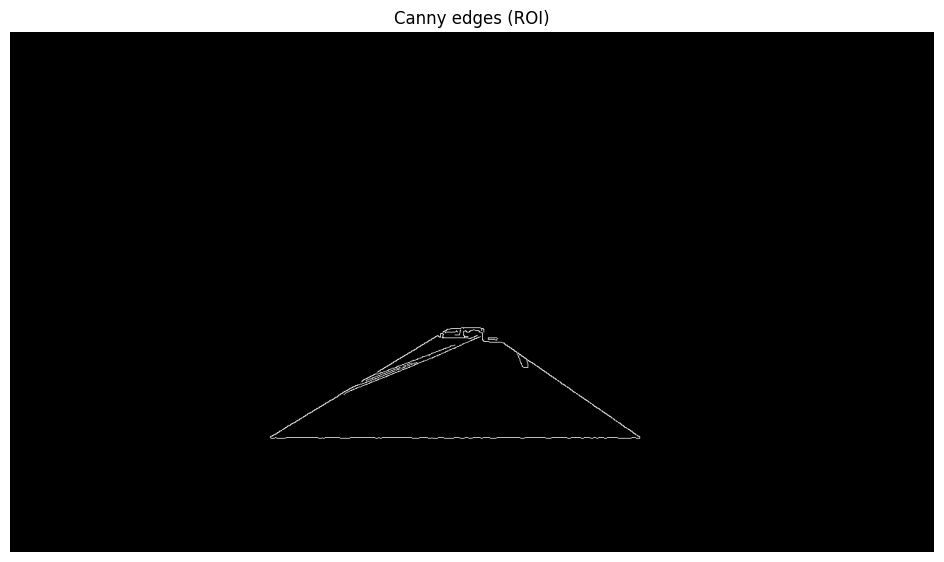

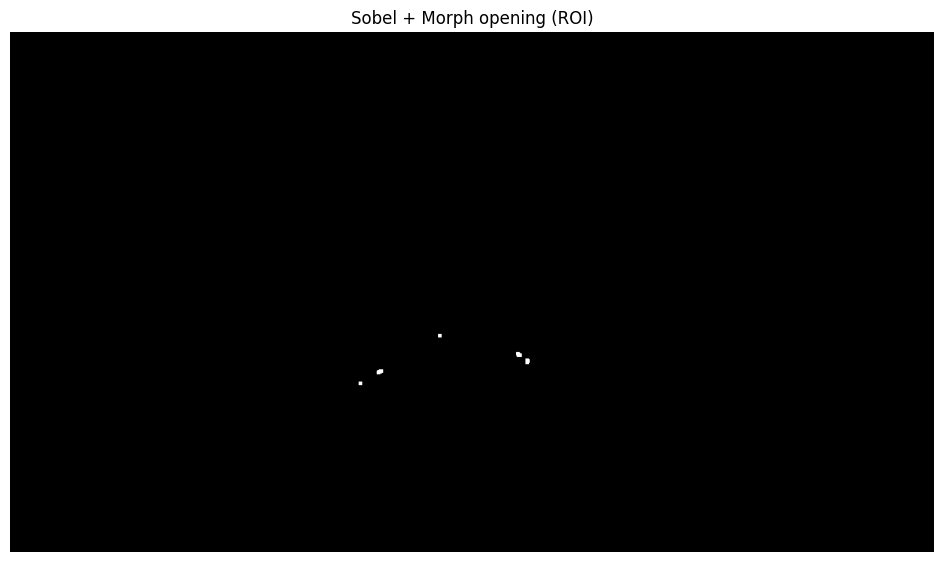

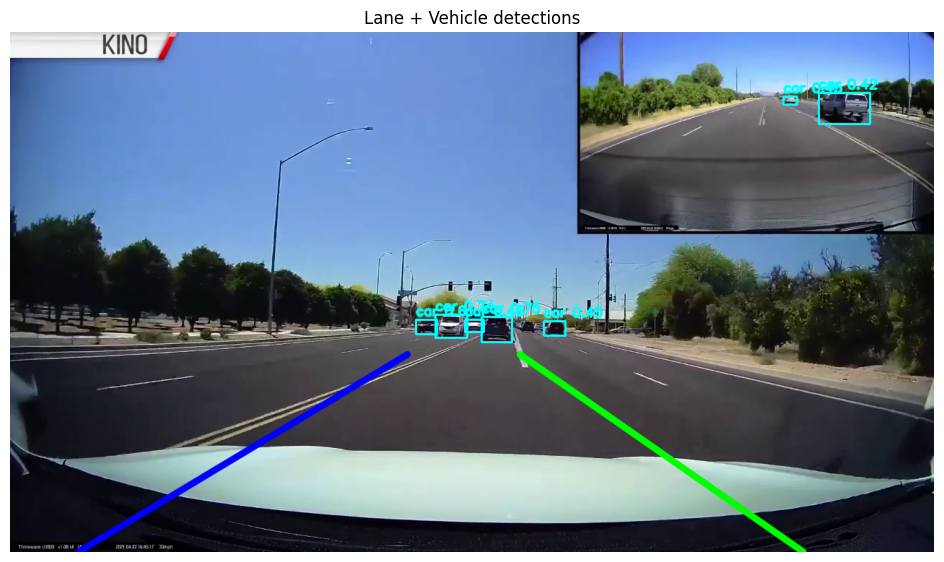

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Không mở được video: {VIDEO_PATH}"

# nhảy đến thời điểm t (giây) nếu muốn
t = 5.5
cap.set(cv2.CAP_PROP_POS_MSEC, t*1000)

ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Không đọc được khung hình đầu tiên")

# ROI
roi_pts = build_trapezoid_roi(frame.shape)
frame_roi, mask_roi = apply_roi_mask(frame, roi_pts)

# Gray + Canny (edge extraction)
gray = cv2.cvtColor(frame_roi, cv2.COLOR_BGR2GRAY)
edges = canny_edges(gray)

# Hough (lane line)
left_line, right_line = hough_lane_lines(edges, frame.shape)

# Sobel + Morph (vehicle edge detection – trực quan)
veh_edges = sobel_morph_edges(gray)
veh_edges_color = cv2.cvtColor(veh_edges, cv2.COLOR_GRAY2BGR)

# YOLO (vehicle detection)
res = yolo(frame, verbose=False, imgsz=960)[0]
boxes, labels = [], []
for b, c, conf in zip(res.boxes.xyxy.cpu().numpy().astype(int),
                      res.boxes.cls.cpu().numpy().astype(int),
                      res.boxes.conf.cpu().numpy()):
    if c in WANTED and conf >= 0.35:
        x1,y1,x2,y2 = b.tolist()
        boxes.append((x1,y1,x2,y2))
        labels.append(f"{yolo.names[int(c)]} {conf:.2f}")

# Vẽ overlay
out1 = draw_lanes(frame.copy(), left_line, right_line)
out2 = draw_boxes(out1, boxes, labels)

# Hiển thị
overlay_roi = frame.copy()
cv2.polylines(overlay_roi, [roi_pts], isClosed=True, color=(255,255,0), thickness=2)

imshow_rgb(overlay_roi, "ROI")
imshow_rgb(cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), "Canny edges (ROI)")
imshow_rgb(veh_edges_color, "Sobel + Morph opening (ROI)")
imshow_rgb(out2, "Lane + Vehicle detections")


In [ ]:
import cv2

def process_video(in_path, out_path, hough_out_path, conf_thr=0.35, show_every=0):
    cap = cv2.VideoCapture(in_path)
    assert cap.isOpened(), f"Không mở được video: {in_path}"

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, (w, h))
    writer_hough = cv2.VideoWriter(str(hough_out_path), fourcc, fps, (w, h))

    roi_pts = None
    miss_lane_cnt = 0
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if roi_pts is None:
            roi_pts = build_trapezoid_roi(frame.shape)

        # ----- LANE DETECTION (Canny + Hough) -----
        # 1) Canny trên toàn bộ frame
        gray_full = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges_full = canny_edges(gray_full)

        # 2) Tạo mask ROI (trắng trong vùng quan tâm, đen ngoài)
        mask = np.zeros((h, w), dtype=np.uint8)           # h, w đã lấy ở đầu hàm
        cv2.fillPoly(mask, [roi_pts], 255)

        # 3) Chỉ giữ edges bên trong ROI
        edges = cv2.bitwise_and(edges_full, edges_full, mask=mask)

        # 4) Hough trên edges đã mask
        left_line, right_line = hough_lane_lines(edges, frame.shape)
        has_lane = (left_line is not None) or (right_line is not None)
        if not has_lane:
            miss_lane_cnt += 1

        # ====== VIDEO Hough ======
        # tạo frame để lưu video Hough
        hough_vis = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        hough_vis = draw_lanes(hough_vis, left_line, right_line)
        writer_hough.write(hough_vis)

        # ====== YOLO ======
        res = yolo(frame, verbose=False, imgsz=960, device=0)[0]
        boxes, labels = [], []
        for b, c, conf in zip(res.boxes.xyxy.cpu().numpy().astype(int),
                              res.boxes.cls.cpu().numpy().astype(int),
                              res.boxes.conf.cpu().numpy()):
            if c in WANTED and conf >= conf_thr:
                x1, y1, x2, y2 = b.tolist()
                boxes.append((x1, y1, x2, y2))
                labels.append(f"{yolo.names[int(c)]} {conf:.2f}")

        # FCDW
        front_idx = select_front_vehicle(boxes, frame.shape, roi_pts)
        status_text = ""
        front_color = (0, 255, 0)
        text_color = (0, 255, 0)

        if front_idx is not None:
            d = estimate_distance_from_box(boxes[front_idx])

            if d < DANGER_DIST:
                status_text = "DANGER"
                front_color = (0, 0, 255)
                text_color = (0, 0, 255)
            elif d < WARN_DIST:
                status_text = "WARNING"
                front_color = (0, 255, 255)
                text_color = (0, 255, 255)
            else:
                status_text = "SAFE"
                front_color = (0, 255, 0)
                text_color = (0, 255, 0)

        # Render output
        out_img = draw_lanes(frame.copy(), left_line, right_line)
        out_img = draw_boxes(out_img, boxes, labels, front_idx=front_idx, front_color=front_color)

        if front_idx is not None and status_text:
            cv2.putText(out_img, status_text, (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, text_color, 3, cv2.LINE_AA)

        writer.write(out_img)

        if show_every > 0 and frame_idx % show_every == 0:
            imshow_rgb(out_img, f"Frame {frame_idx}", size=8)
            imshow_rgb(hough_vis, f"Hough {frame_idx}", size=8)

        frame_idx += 1

    cap.release()
    writer.release()
    writer_hough.release()
    print(f"Đã lưu video output tại: {out_path}")
    print(f"Đã lưu video Hough tại: {hough_out_path}")
    print(f"Miss lane count: {miss_lane_cnt}")

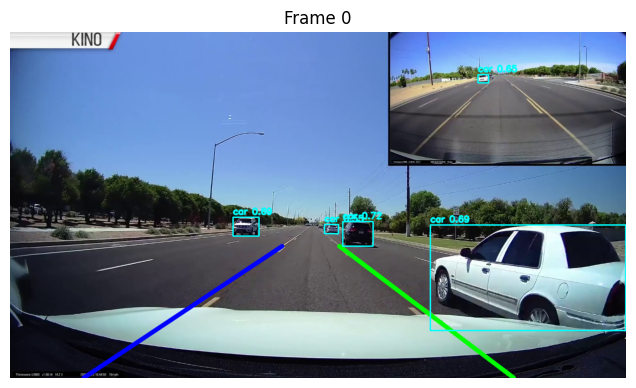

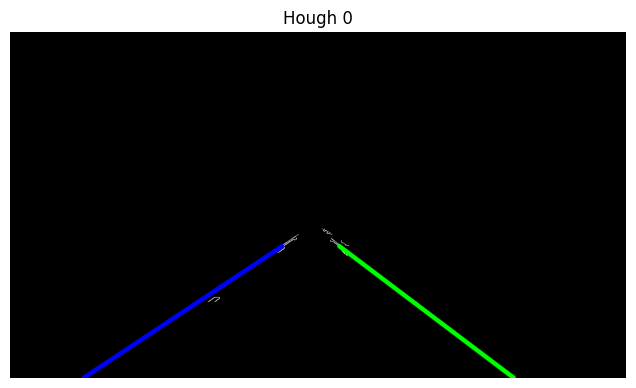

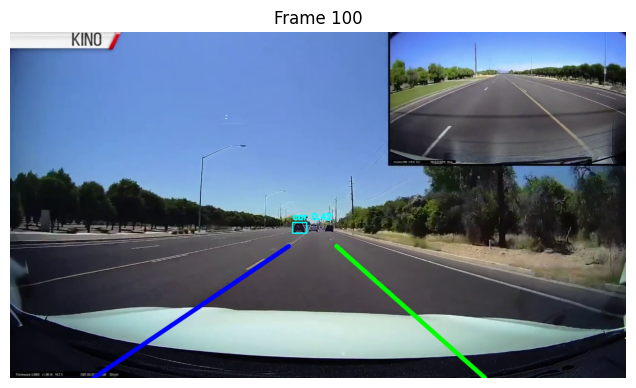

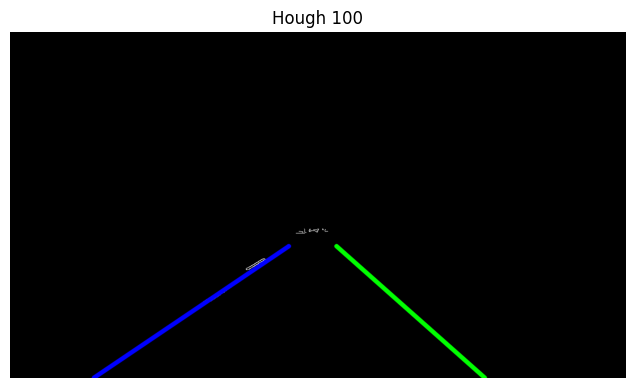

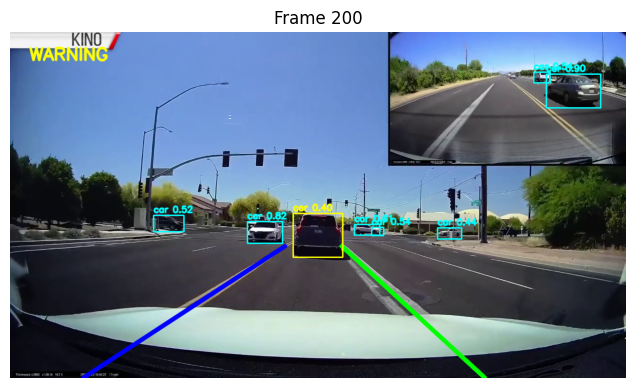

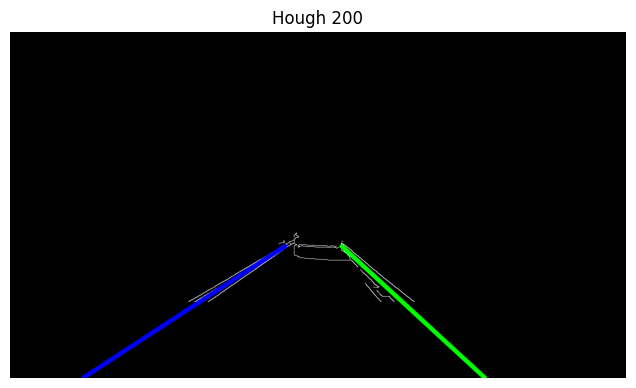

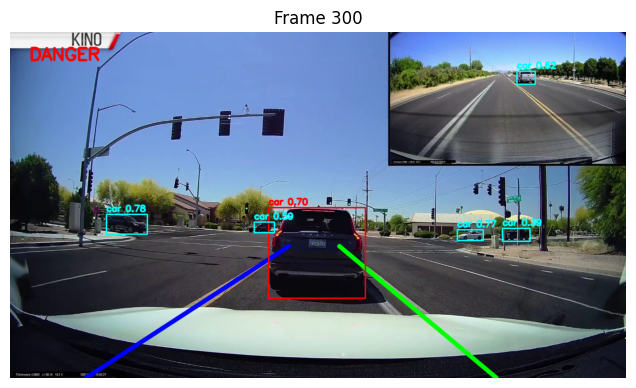

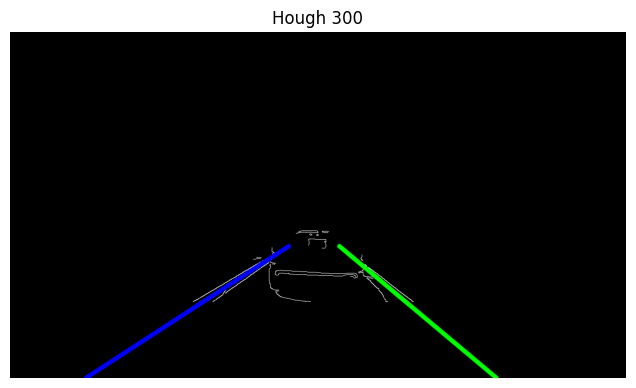

Đã lưu video output tại: /content/output/car_fcdw.mp4
Đã lưu video Hough tại: /content/output/car_hough.mp4
Miss lane count: 15


In [ ]:
IN_VIDEO = VIDEO_PATH  # hoặc đường dẫn khác
OUT_VIDEO1 = OUT_DIR / "car_fcdw.mp4"
OUT_VIDEO2 = OUT_DIR / "car_hough.mp4"

process_video(str(IN_VIDEO), str(OUT_VIDEO1), str(OUT_VIDEO2), conf_thr=0.35, show_every=100)

In [ ]:
from google.colab import files
files.download('/content/output/car_fcdw.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import time
import torch
from ultralytics import YOLO

def measure_yolo_fps(video_path, imgsz=960):
    # Load model + đưa lên GPU
    yolo = YOLO("yolov8n.pt")
    yolo.to("cuda")

    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), f"Không mở được video: {video_path}"

    # Warm-up (để GPU ổn định)
    ret, frame = cap.read()
    for _ in range(10):
        _ = yolo(frame, verbose=False, imgsz=imgsz)
    torch.cuda.synchronize()

    # Bắt đầu đo
    frame_count = 0
    t0 = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # YOLO-only inference
        _ = yolo(frame, verbose=False, imgsz=imgsz)
        frame_count += 1

    # Đồng bộ GPU trước khi tính thời gian
    torch.cuda.synchronize()
    t1 = time.time()

    dt = t1 - t0
    fps = frame_count / dt

    print(f"YOLO-only FPS (imgsz={imgsz}): {fps:.2f}")
    print(f"Tổng số frame: {frame_count}")
    print(f"Tổng thời gian: {dt:.2f} s")

    cap.release()
    return fps

# ---- chạy đo ----
fps_yolo = measure_yolo_fps(VIDEO_PATH, imgsz=960)

YOLO-only FPS (imgsz=960): 73.36
Tổng số frame: 382
Tổng thời gian: 5.21 s
